# IMDB Movie Analysis

In this Exploratory Data analysis I will analyse "IMDB movies dataset" from Kaggle - https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset. This will be my first ever analysis using Python and Jupiter Notebook therefore I will only focus on performing Exploratory analysis.

IMDB is an online database of information related to movies – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. Within this exploratory data analysis (EDA), my aim is to delve into the various attributes and statistics of movies, utilizing visualizations and graphs.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("imdb_movies.csv")

##### Data preparation and cleaning steps
1. Check for duplicate rows
2. Fix any missing or incorrect values
3. Rename the columns
4. Formatting data
5. Create any additional data

First step is to check for duplicates. We can see, that the sum shows that there are no duplicate rows in this dataset

In [3]:
df.duplicated().sum()

0

Next, we want to spot any missing values in the dataset. From this we can see that there are 85 rows with missing values and 39 rows with missing values in crew field.

In [5]:
df.isna().sum() #Checking for missing values in columns

names          0
date_x         0
score          0
genre         85
overview       0
crew          39
orig_title     0
status         0
orig_lang      0
budget_x       0
revenue        0
country        0
dtype: int64

After examining the rows with missing values for column 'genre' and 'crew' we conclude the missing values contain an insignificant portion of the data and include errors therefore the 124 rows (1.2% from total) can be removed. 

In [6]:
df.dropna(subset=['genre'], inplace=True) #dropping NA
df.reset_index(drop=True, inplace=True)

In [7]:
df.dropna(subset=['crew'], inplace=True) #dropping NA
df.reset_index(drop=True, inplace=True)

After reading the column description of the dataset on Kaggle I understand that the column 'country' might get misunderstood, therefore it was renamed. As for the budget and revenue columns, to make it easier to read the data, I will transform the numbers in millions in the following steps.

In [8]:
df = df.rename(columns={'budget_x': 'budget_mil', 
                        'revenue': 'revenue_mil', 
                        'date_x': 'date', 
                        'country': 'release_country'}) #Renaming columns

In [9]:
df['budget_mil'] = df['budget_mil'] / 10**6 #Removing decimals to see only full millions

In [10]:
df['revenue_mil'] = df['revenue_mil'] / 10**6 #Removing decimals to see only full millions

We have revenue and budget columns, I'm curious to see how well the movies are doing in terms of income. We can look at this through a simple approach by deducting budget from revenue. While it may not describe actual income, since normally there is additional marketing expenditure,profit sharing with production companies and cinemas, it will give us a general overview. Therefore a new column has been created.

In [11]:
df['income_mil'] = (df['revenue_mil'] - df['budget_mil']) #creating a new P/L column

I want to format the columns to have 2 decimals only, so first I want to check which type these columns currently are.

In [12]:
type = df.dtypes
print(type)

names               object
date                object
score              float64
genre               object
overview            object
crew                object
orig_title          object
status              object
orig_lang           object
budget_mil         float64
revenue_mil        float64
release_country     object
income_mil         float64
dtype: object


In [13]:
df['budget_mil'] = df['budget_mil'].round(2)
df['revenue_mil'] = df['revenue_mil'].round(2)
df['income_mil'] = df['income_mil'].round(2)

From date column, only year will be used in charts for time-series analysis, therefore for sake of simplicity a year column is created.

In [14]:
df['date'] = pd.to_datetime(df['date']) 
df['year'] = df['date'].dt.year #creating a new year column

For more variation of the analysis, two categorical columns are created 'budget_tier' and 'profitable'.

In [15]:
df['primary_genre'] = df['genre'].apply(lambda x: x.split(',')[0]) #creating a primary genre column
df['budget_tier'] = df['budget_mil'].apply(lambda x: "Low" if x < 5 \
                                             else "Mid" if 5 <= x <= 50 \
                                             else "High" if 50 < x <= 150 \
                                             else "Blockbuster") #creating a column with budget tier for every row
df['profitable'] = df['income_mil'].apply(lambda x: "Yes" if x > 0 else "No")

Now I will drop the columns, which we won't be using so that the dataframe is not as wide and easier to overview.

In [16]:
df = df.drop(['date', 'genre','overview','crew','orig_title','status','orig_lang','release_country'], axis=1)

###### Handling errors in data
While looking at how data is descibed, I noticed that the multiple values in columns such as 'score', 'revenue_mil' and 'budget_mil' equals 0. It may be possible that the movie is not rated and the budget, revenue data is not available online, however it also leads me to think there may be some errors in the dataset.

After inspecting further and cross-checking the movie names with IMDB online, I concluded that the 0's are actually errors or caused by unavailability of data. I went a step further and contacted the owner of the dataset in Kaggle to inquire about the possibility of this dataset containing errors, to which I got response: "KNN Machine Learning algorithm was used to fill in the missing values as it gave better results than other methods to handle the missing data, so there may be some possible errors".

The presence of such errors compromises the integrity and reliability of the dataset, which could lead to inaccurate and misleading results. 

In [17]:
df.describe()

,score,budget_mil,revenue_mil,income_mil,year
count,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000
mean,63.819734,63.411742,245.693006,182.281237,2007.748298
std,12.591810,56.513534,273.489406,238.169102,15.340603
min,0.000000,0.000000,0.000000,-340.000000,1903.000000
25%,59.000000,14.000000,26.920000,4.890000,2001.000000
50%,65.000000,49.000000,139.630000,79.560000,2013.000000
75%,71.000000,103.400000,408.420000,305.740000,2019.000000
max,100.000000,460.000000,2923.710000,2686.710000,2023.000000


One of the ways considered for handling these errors in the dataset was imputation. However, after careful consideration, I concluded that imputing the values would not be the optimal solution. 

The errors were not limited to a few isolated instances but were scattered across multiple rows and variables. Attempting to impute these errors would require implementing complex imputation techniques, therefore a decision was made to remove the rows.

In [18]:
df = df[df.score != 0]
df = df[df.revenue_mil != 0]
df = df[df.budget_mil != 0]

Now a final check is performed to see how a data looks. We can still see that there movies with budget of budget very close to zero, but when investigating further, it was concluded that the count of such movies is insignificant and those actually might be beginner movies with micro-budgets, therefore, consequently, not generating any revenue either.

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
score,9586.0,64.824431,9.837233,10.00,59.00,66.000,71.0000,100.00
budget_mil,9586.0,61.892544,54.246309,0.01,14.00,47.405,102.0000,460.00
revenue_mil,9586.0,249.680817,275.624038,0.01,27.98,138.825,414.0225,2923.71
income_mil,9586.0,187.788244,238.661490,-199.55,7.69,87.165,312.3375,2686.71
year,9586.0,2007.530565,15.325158,1903.00,2001.00,2012.000,2019.0000,2023.00


## Data Exploratory Analysis (EDA) part

In [20]:
df.head(5)

,names,score,budget_mil,revenue_mil,income_mil,year,primary_genre,budget_tier,profitable
0,Creed III,73.0,75.0,271.62,196.62,2023,Drama,High,Yes
1,Avatar: The Way of Water,78.0,460.0,2316.79,1856.79,2022,Science Fiction,Blockbuster,Yes
2,The Super Mario Bros. Movie,76.0,100.0,724.46,624.46,2023,Animation,High,Yes
3,Mummies,70.0,12.3,34.20,21.90,2023,Animation,Mid,Yes
4,Supercell,61.0,77.0,340.94,263.94,2023,Action,High,Yes


Initially, I would like to examine the dataset's distribution and the spread of numeric columns. Although I have a general understanding from the data description, a histogram would provide a clearer visualization.

Considering the mean of 64.8 and a standard deviation of 9.8, the distribution of 'IMDB Rating' is moderately wide with a gentle slope. Approximately 68% of values fall within one standard deviation (9.8) of the mean (64.8), indicating a range of 55-74.6.

The distributions of 'Revenue,' 'Budget,' and 'Income' exhibit a right-skewed pattern, indicating that the majority of movies have lower budgets, revenues, and incomes. On the other hand, 'Year' follows a left-skewed distribution, suggesting that newer movies constitute the largest volume, gradually decreasing with older movies.

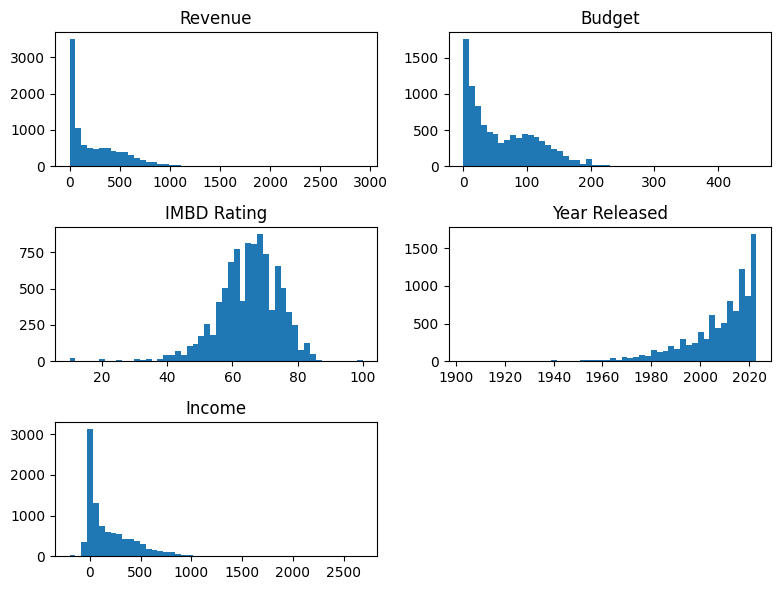

In [21]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(8,6))
his1= df['score']
his2= df['budget_mil']
his3= df['revenue_mil']
his4= df['year']
his5= df['income_mil']

axes[0,0].hist(his3, bins=50)
axes[0,0].set_title('Revenue')
axes[0,1].hist(his2, bins=50)
axes[0,1].set_title('Budget')
axes[1,0].hist(his1, bins=50)
axes[1,0].set_title('IMBD Rating')
axes[1,1].hist(his4, bins=50)
axes[1,1].set_title('Year Released')
axes[2,0].hist(his5, bins=50)
axes[2,0].set_title('Income')

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

By examining the maximum values and the highly skewed distributions, I deduce that the Interquartile Range (IQR) would be the most suitable measure of variability for a dataset with outliers. Since 'budget_mil,' 'revenue_mil,' and 'income_mil' are interrelated, I will focus on revenue grouped by budget tiers rather than income.

Upon analyzing the boxplots, it becomes evident that movies with high and blockbuster budgets have a wider spread and box (representing 50% of the values), while those with mid and lower budgets exhibit lower spread and narrower boxes. To investigate further, I created separate boxplots for budget tier pairs. All budget tiers have outlier values.

For movies with low and mid budgets, I noticed that the median does not align with the center of the box, indicating significant skewness in the revenue data for these tiers. Additionally, a considerable number of outliers are present in the low and mid budget tiers, prompting further investigation. Upon cross-checking some data, I concluded that these outliers represent movies that performed exceptionally well, occurring more by chance than error.

<Axes: xlabel='budget_tier', ylabel='revenue_mil'>

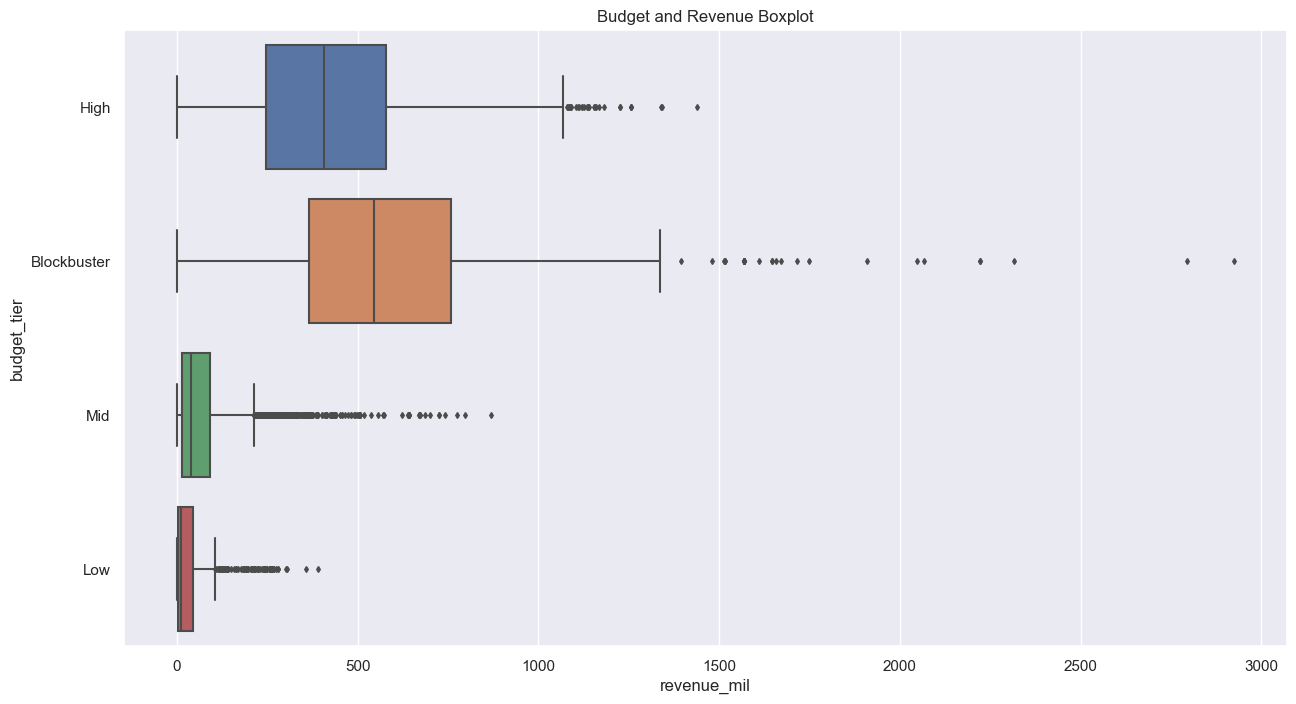

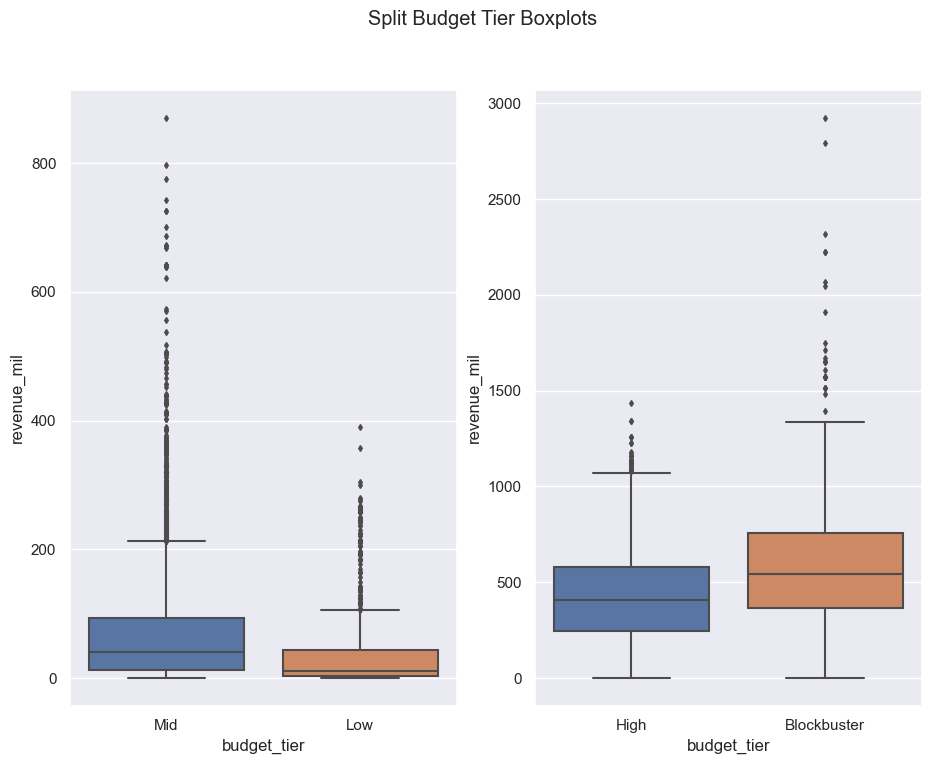

In [22]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.boxplot(data=df, x="revenue_mil", y="budget_tier", fliersize=3).set_title('Budget and Revenue Boxplot')

low_mid_tier = df[df['budget_tier'].isin(['Low','Mid'])]
high_bb_tier = df[df['budget_tier'].isin(['High','Blockbuster'])]

fig, axes = plt.subplots(1, 2, figsize=(11, 8))
fig.suptitle('Split Budget Tier Boxplots')

sns.boxplot(ax=axes[0], data=df, y='revenue_mil', x=low_mid_tier['budget_tier'],orient='v',fliersize=3)
sns.boxplot(ax=axes[1], data=df, y='revenue_mil', x=high_bb_tier['budget_tier'],orient='v',fliersize=3)

Considering the left-skewed nature of the 'Year' column, I have decided to focus my analysis on movies released in approximately the last 40 years. This choice is motivated by limited and mostly missing data for older movies and the need to adjust revenue and budget figures for inflation to ensure objective comparisons. Upon inspection, I discovered only a small subset of movies released before 1980, which comprise 5% of the initial dataset.

In [34]:
old_movie_count = (df['year'] <= 1980).sum()
old_movie_count

596

In [24]:
df_adj = df[df['year'] >= 1980]

### Budget and Revenue

In this section, I will conduct a time-series and relationship analysis for the budget and revenue columns. The first graph below illustrates the median revenue and budget over the years. Notably, the revenue line consistently surpasses the budget line throughout history. However, I would like to draw attention to the widening gap between these two measures, particularly in recent years.

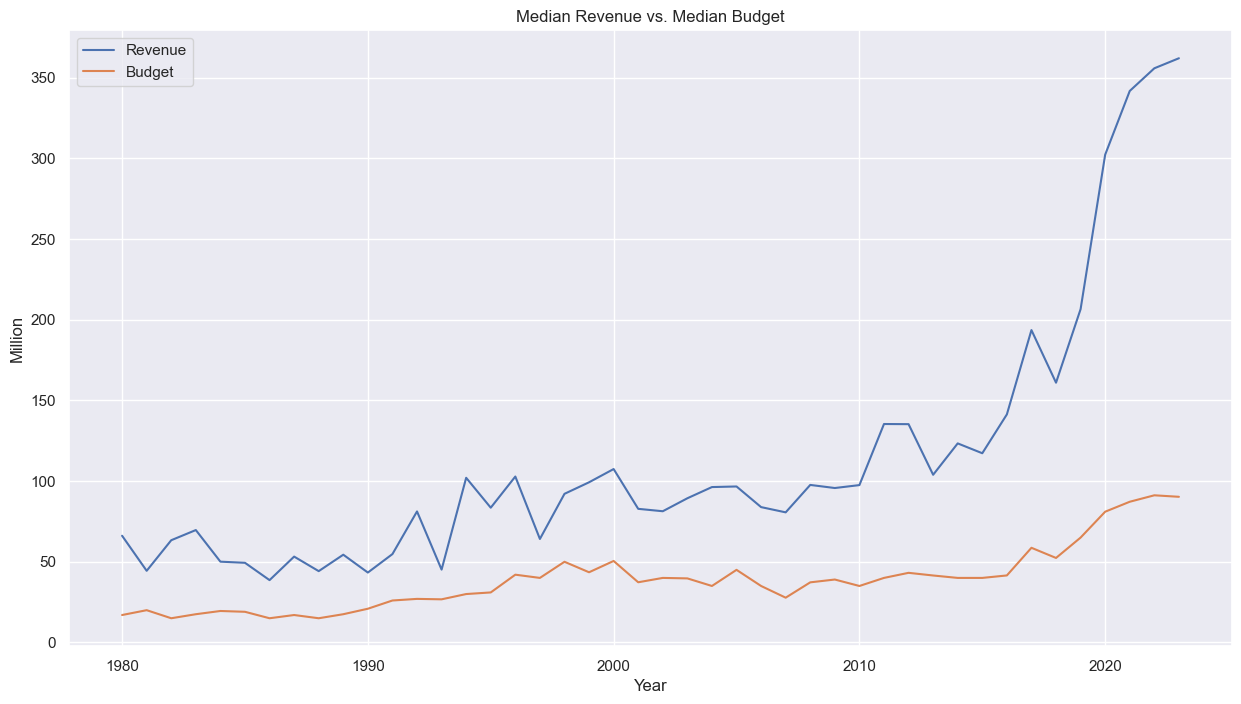

In [25]:
df_revsum = df_adj.groupby('year')['revenue_mil'].median()
df_revsum.plot()
df_revbudget = df_adj.groupby('year')['budget_mil'].median()
df_revbudget.plot()

plt.title('Median Revenue vs. Median Budget')
plt.ylabel('Million')
plt.xlabel('Year')
plt.legend(["Revenue","Budget"], loc=2)

I was intrigued to identify the movie genre responsible for the substantial revenue growth observed from the year 2000 and present. Therefore, I created a stacked area chart displaying the median revenue grouped by the eight most popular genres and others. The chart reveals that the revenue surge during those years originated from movies in genres such as comedy, drama, thriller, science fiction, horror, and Other.

Text(0.5, 1.0, 'Median Revenue by Movie Genres (2000-2023)')

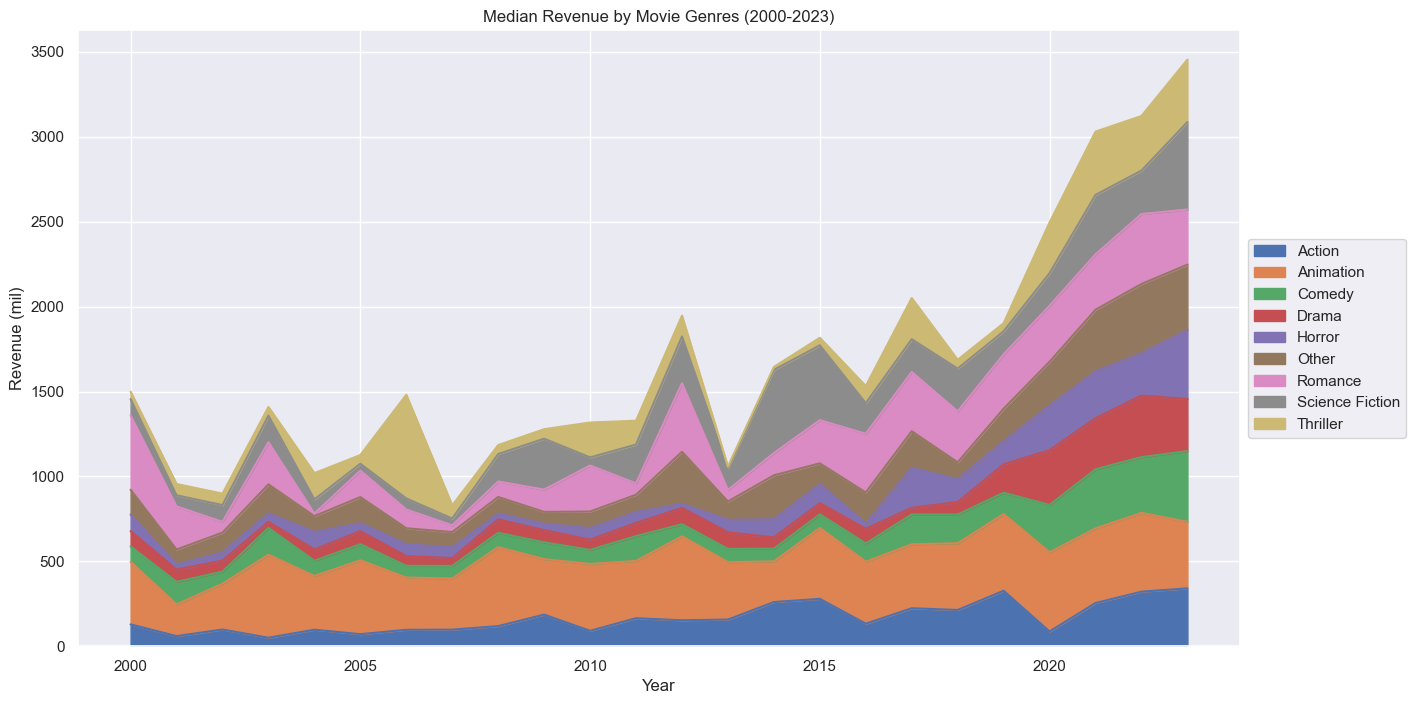

In [26]:
genres_to_replace = ['Adventure', 'Crime', 'Family', 'Fantasy', 'History',
                     'Music', 'Mystery', 'War', 'Western']
df_replaced = df_adj.copy()
df_replaced['primary_genre'] = df_adj['primary_genre'].replace(genres_to_replace, 'Other')

df_rev_growth = df_replaced[df_replaced['year'] >=2000]
table = pd.pivot_table(df_rev_growth,values='revenue_mil', index='year', columns='primary_genre', aggfunc='median')
table.plot(kind='area')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('Revenue (mil)')
plt.xlabel('Year')
plt.title('Median Revenue by Movie Genres (2000-2023)')

To delve deeper into this phenomenon, I aimed to explore the factors driving the sudden revenue spike over the past five years. In the line graph below, I plotted the movie count over time, categorized by budget tiers.

Remarkably, the count of high-budget tier movies has exponentially increased in the last five years. Initially, this trend may be attributed to the effects of COVID-19 combined with rising production costs. An online research of this topic revealed that "big studios seek big blockbusters, especially during COVID-19, as they generate more revenue," and "due to COVID, budgets from previous years cannot be directly compared to film production budgets during the pandemic."

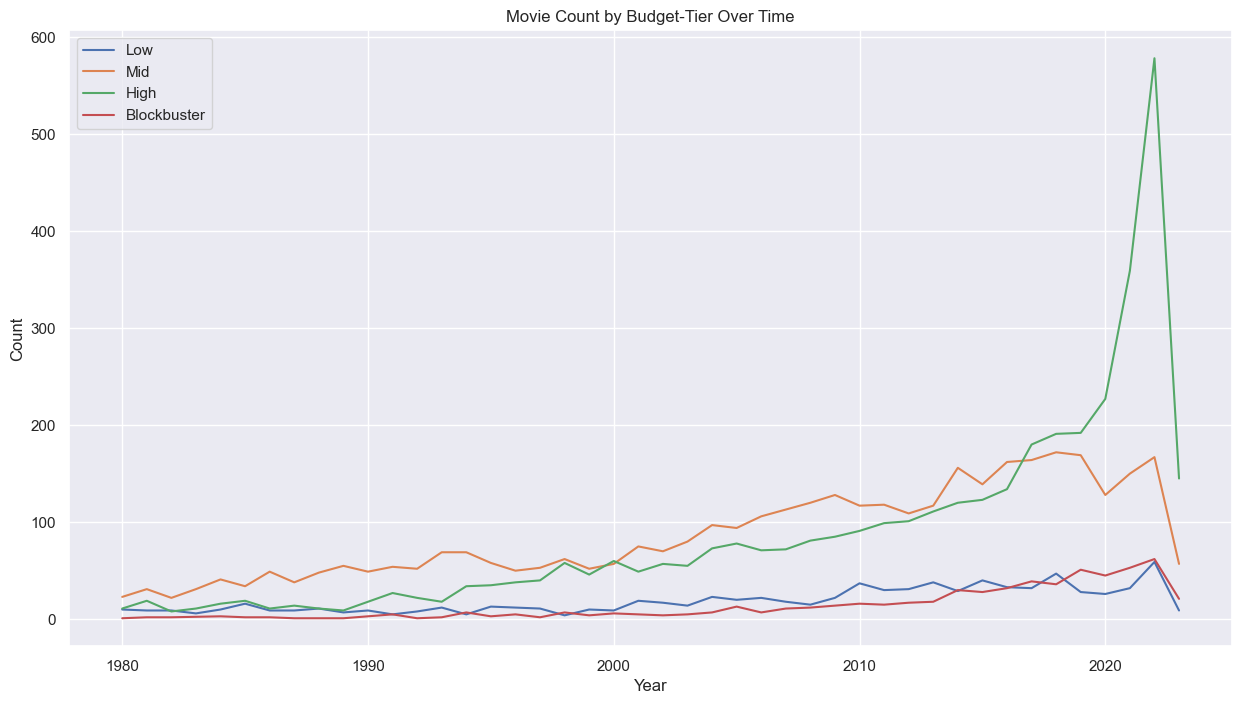

In [27]:
low_t = df_adj[df_adj['budget_tier'] == 'Low']
mid_t = df_adj[df_adj['budget_tier'] == 'Mid']
high_t = df_adj[df_adj['budget_tier'] == 'High']
bb_t = df_adj[df_adj['budget_tier'] == 'Blockbuster']

df_low_t = low_t.groupby('year')['budget_tier'].count()
df_low_t.plot()
df_mid_t = mid_t.groupby('year')['budget_mil'].count()
df_mid_t.plot()
df_high_t = high_t.groupby('year')['budget_tier'].count()
df_high_t.plot()
df_bb_t = bb_t.groupby('year')['budget_mil'].count()
df_bb_t.plot()

plt.title('Movie Count by Budget-Tier Over Time')
plt.ylabel('Count')
plt.xlabel('Year')
plt.legend(["Low","Mid","High","Blockbuster"], loc=2)

A bar chart below depicts the budget distribution across different genres of movies. It is evident that genres like Comedy, Drama, and Horror have comparatively lower budgets, reflecting the lower costs involved in creating such movies. In contrast, genres like Animation, Science Fiction, Action, and Romance require higher budgets.

Text(0.5, 0, 'Genre')

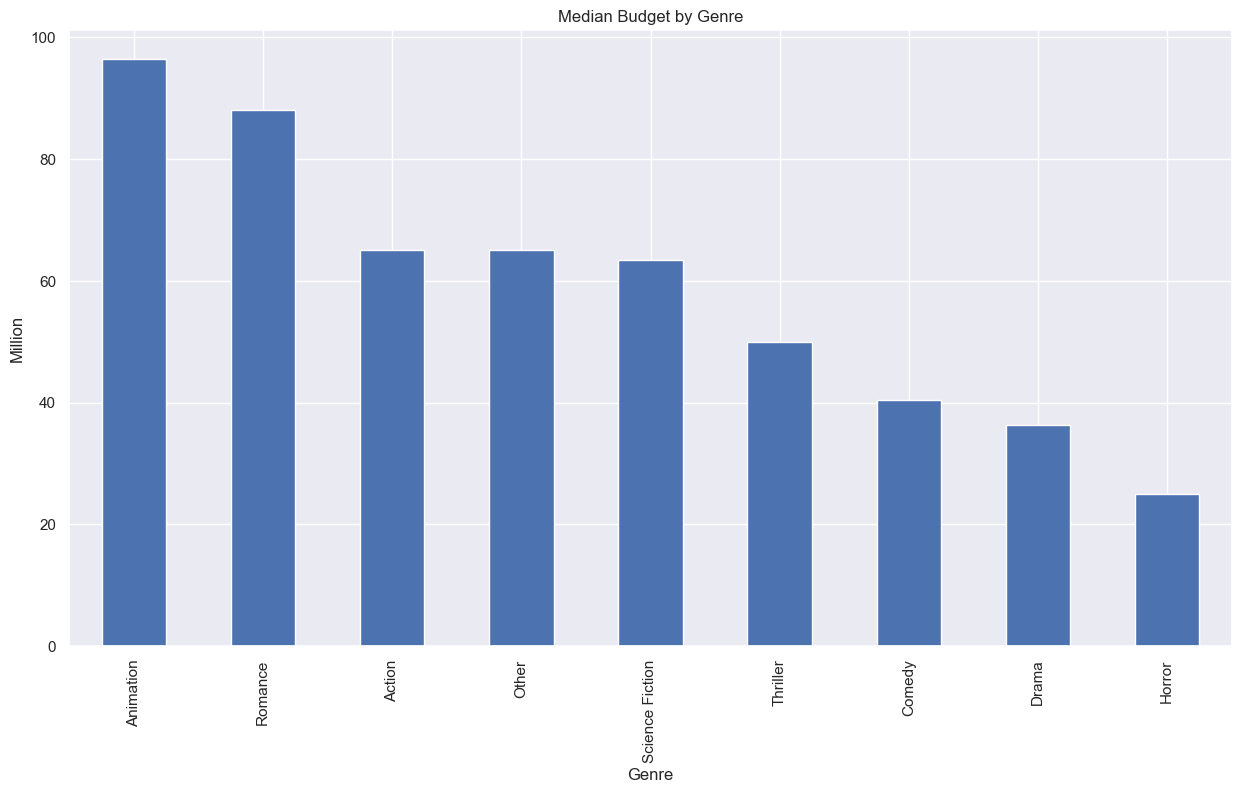

In [28]:
df_genres = df_replaced[df_replaced['year'] >=2000]

df_gmed = df_genres.groupby('primary_genre')['budget_mil'].median().sort_values(ascending=False)
df_gmed.plot(kind='bar')

plt.title('Median Budget by Genre')
plt.ylabel('Million')
plt.xlabel('Genre')

Additionally, it is interesting to examine the relationship between budget and revenue. I aim to determine if an increase in budget correlates with higher movie revenue. The scatterplot clearly demonstrates a moderate positive correlation between a movie's budget and its revenue. This correlation is logical since occasionally, movies may underperform despite having a large budget.

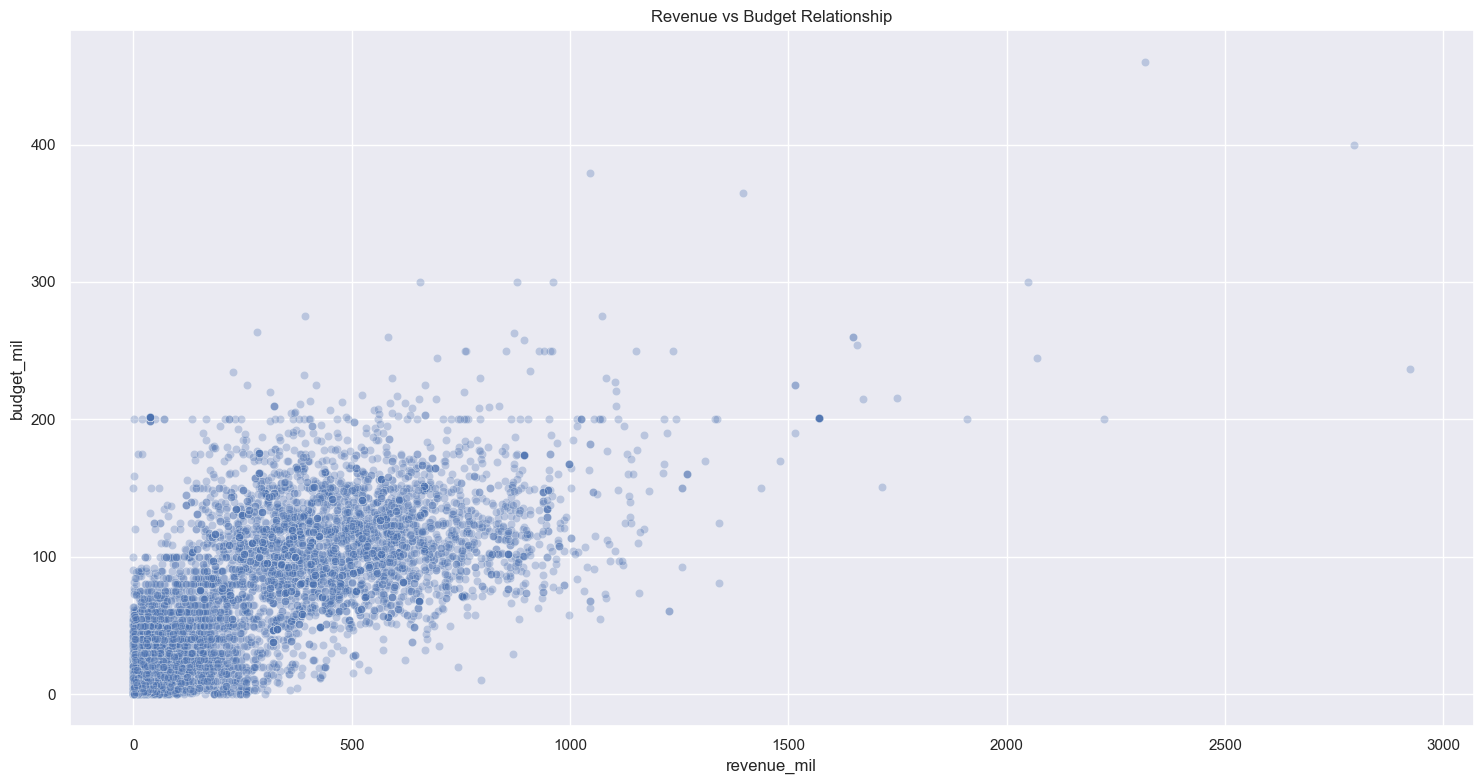

In [29]:
sns.scatterplot(
    x="revenue_mil", 
    y="budget_mil",
    data=df_adj,
    alpha=0.3)
plt.title('Revenue vs Budget Relationship')

plt.tight_layout()

### Income

Another intriguing aspect of the data is the profitability ratio of movies grouped by genres. The first stacked bar chart below depicts the total movie count categorized by genre and stacked by the count of profitability (yes/no) values. Notably, drama, action, comedy, horror, and animation are the genres with the highest movie counts in the last 43 years.

Examining the stacked percentage bar chart, we can observe the profitability ratio for each genre. Although there are no major differences, genres such as animation, comedy, and family exhibit the highest percentages of profitable movies.

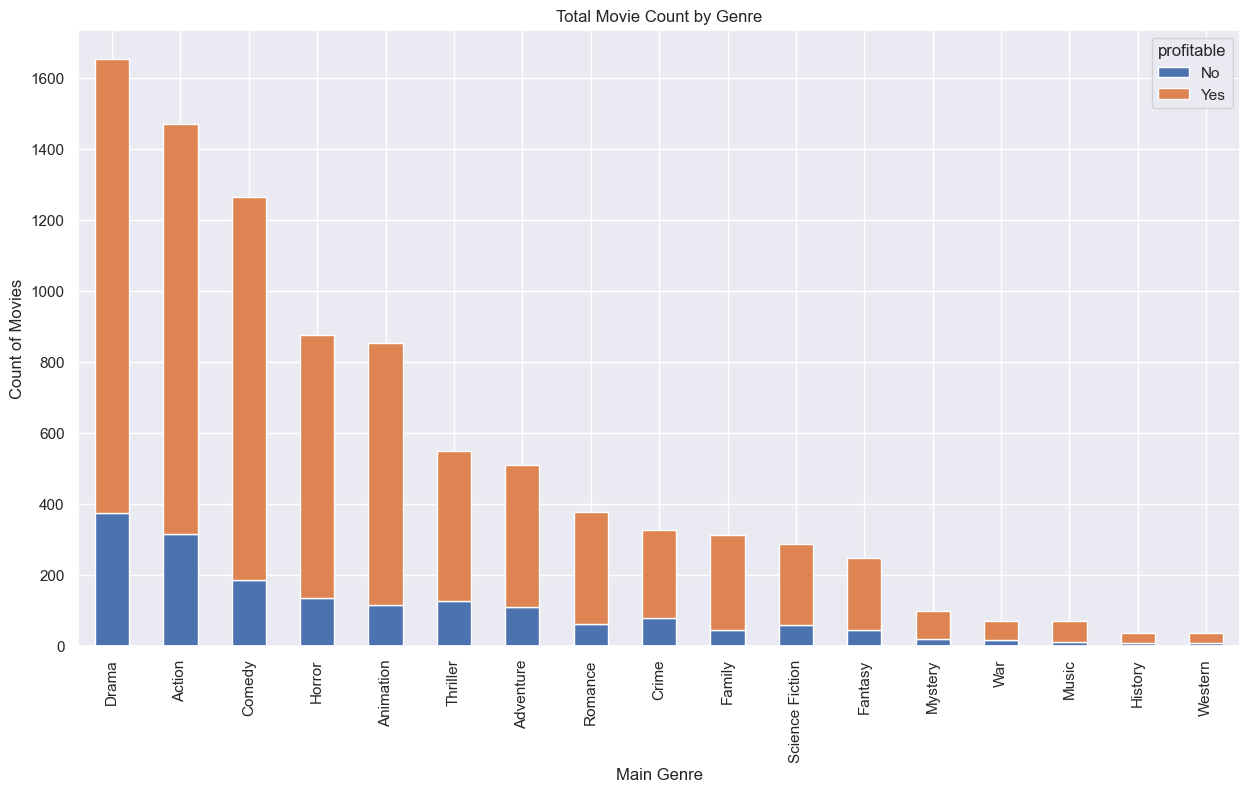

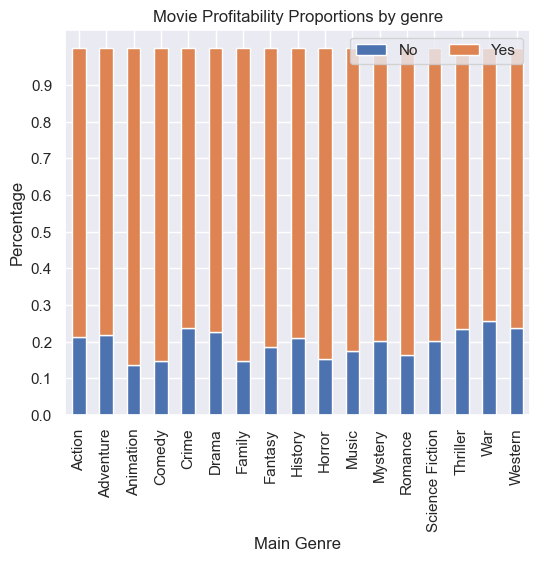

In [30]:
grouped = df_adj.groupby(['primary_genre','profitable']).size().unstack()
sorted_df = grouped.sum(axis=1).sort_values(ascending=False)
grouped_sorted = grouped.loc[sorted_df.index]
grouped_sorted.plot(kind='bar', stacked=True)
plt.xlabel("Main Genre")
plt.ylabel("Count of Movies")
plt.title('Total Movie Count by Genre')

cross_tab_prop = pd.crosstab(index=df_adj['primary_genre'],
                             columns=df_adj['profitable'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True,  
                    figsize=(6, 5))

plt.legend(loc="upper right", ncol=2)
plt.xlabel("Main Genre")
plt.ylabel("Percentage")
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.title('Movie Profitability Proportions by genre')
plt.show()

### Relationship Heatmap

By referring to the correlation heatmap, we observe that only the income & budget and revenue & budget relationships demonstrate a moderate positive correlation. The remaining relationships do not indicate any significant correlation. It is worth noting that the nearly perfect linear positive correlation between income and revenue, is not to be taken into account as something interesting due to these columns being directly linked.

Text(0.5, 1.0, 'Correlation Matrix')

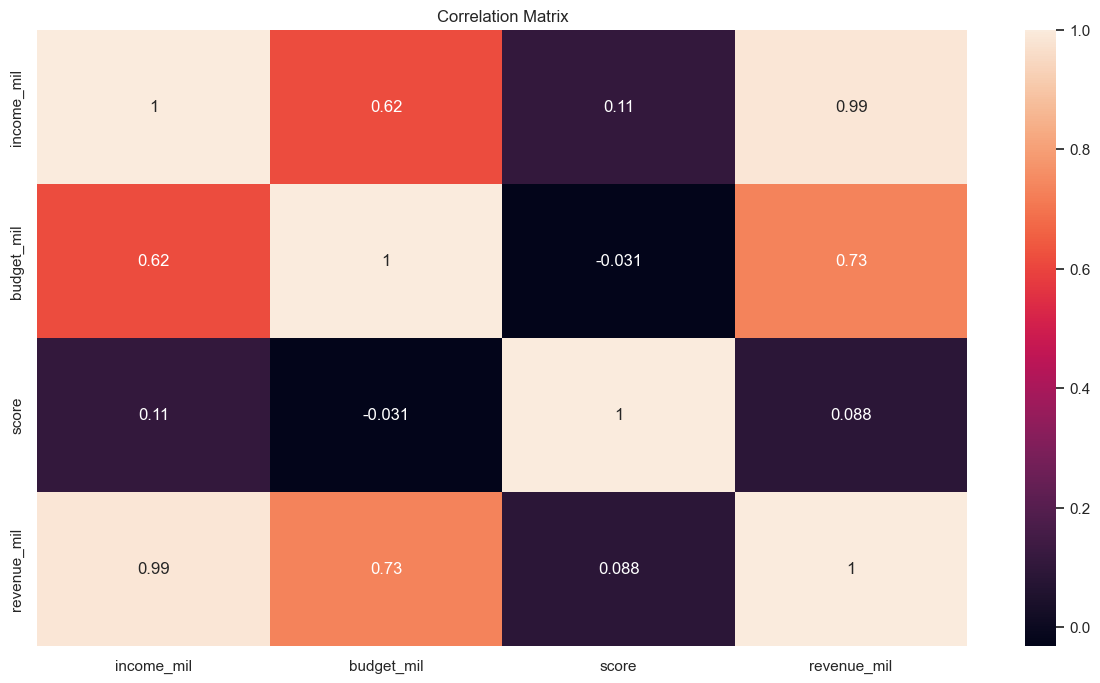

In [31]:
df_corr = df_adj[['income_mil','budget_mil','score','revenue_mil']].corr()
sns.heatmap(df_corr, annot=True).set_title('Correlation Matrix')

## Summary and conclusions

1. Movies with higher budgets exhibit wider spreads in terms of revenue, while those with lower budgets have narrower spreads. Outliers can be found across all budget tiers, and movies with lower budgets often show more skewed revenue data, likely due to a some exceptionally successful films.

2. Over the past four decades, movie budgets have increased by a factor of 2, while movie revenues have significantly increased by a factor of 7. The disparity between budgets and revenues has widened, particularly from 2018 to 2023. Generally revenues have increased across all genres, but the increase can be largely attributed to genres like comedy, drama, thriller, science fiction, and horror. 

3. The count of high-budget movies has notably risen in the past five years. These movies generate larger revenues, partly due to a more diverse revenue distribution. Big studios prioritize high-budget films for greater revenue generation, particularly during the pandemic, contributing to the rise in their count.

3. Among the movies in the original dataset, around 65% belong to the top five primary genres: Drama, Action, Comedy, Animation, and Horror. These genres have a higher count because they are more cost-effective to produce, resulting in easier accessibility for filmmakers. Consequently, movies with lower budgets tend to have higher counts.

4. Only 17% of the movies in the dataset have a negative income (budget-revenue). Certain genres like Documentary, Animation, and TV Movie have a slightly higher proportion of profitability, while genres like War, Crime, and Adventure have a lower likelihood of being profitable.

5. There is a moderate positive correlation between a movie's budget and its income, and a stronger positive correlation between budget and revenue. This relationship is expected, although it is worth noting that movie performance can still vary regardless of the budget.